# Python helper file/script for MATLAB

This cell sets up the notebook to import numpy, seaborn, pandas, matplotlib etc.

In [1]:
# Run this cell to set up the notebook.

# These lines import the Numpy, Pandas, Seaborn, Matplotlib modules.
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt

# Importing plotting libraries and styles
%matplotlib inline
plt.style.use('fivethirtyeight')

# For Pandas to ignore FutureWarning displays
import warnings
warnings.simplefilter('ignore', FutureWarning)

### The cell given below sets up MATLAB for the notebook
Source: https://sehyoun.com/blog/20180904_using-matlab-with-jupyter-notebook.html

In [2]:
import matlab.engine
import io
import scipy.io
from IPython.core.magic import register_cell_magic
ip = get_ipython()

out = io.StringIO()
err = io.StringIO()

# Setup matlab cell magic #
@register_cell_magic
def matlab_magic(line,cell):
    out.truncate(0)
    out.seek(0)
    err.truncate(0)
    err.truncate(0)
    raw = '''{line}.eval("""{cell}""", nargout=0, stdout=out, stderr=err)'''
    ip.run_cell(raw.format(line=line, cell=cell))
    print(out.getvalue())
    print(err.getvalue())
    
# Starting a MATLAB engine called eng
eng = matlab.engine.start_matlab()

**Note:** Change this to the file path on your computer.

In [3]:
# Adds the MMB.m as well as MMBOPT1.m and MMBOPT2.m folders to the MATLAB engine path"
eng.addpath(r'/Users/Desktop/monetaryPolicy/mmb-gui-mlab-2.3.2', nargout=0)
eng.addpath(r'/Users/Desktop/monetaryPolicy/mmb-gui-mlab-2.3.2/MMB_OPTIONS', nargout=0)
eng.addpath(r'/Users/Desktop/monetaryPolicy/scripts', nargout=0)

# Important:
The code below sets the coefficients and other data for the PID rule to work.

Check out the coefficients table here:

https://rishab231.github.io/img/coefficients.png

In [4]:
# This sets the coefficients of the monetary policy rule, there are 33 coefficients and len(coefficients) = 33
coefficients = [0, 0, 0, 0, 1.5/4, 1.5/4, 1.5/4, 1.5/4, 
                0, 0, 0, 0, 0, 0.5, 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 1, 0.25]

# Number of the model you want to chooose, please exclude 69-79, 19-22, 27, 59, 65, 68, 81, 97, 98
modelNum = 1

scipy.io.savemat('variables.mat', dict(coefficients=coefficients, modelNumber = modelNum))

## **Important:** 
The cell below runs the MMB.m file

In [5]:
eng.MMB(nargout = 0)

### Functions defined to import data for:
* 4 IRF: Impulse Response Function Variables (outputgap, inflation, interest, output) and `modelName`
* All IRF Variables
* 4 ACF: Autocorrelation Function Variables (outputgap, inflation, interest, output)
* **Unconditional Variances**


In [6]:
def getModelName():
    irf_4 = pd.read_excel("../mmb-gui-mlab-2.3.2/OUTPUT/results.xls", sheetname = "IRF Mon. Pol. Shock      ")
    irf_4 = irf_4.T
    irf_headers = irf_4.iloc[0] # grab the first row for the header
    irf_4 = irf_4[1:] # take the data less the header row
    irf_4_stripped_headers = [myHeader.strip() for myHeader in np.array(irf_headers)] # removing trailing whitespaces
    irf_4.columns = irf_4_stripped_headers
    modelName = irf_4.columns.values[1]
    return modelName

def singleModel_irf4():
    irf_4 = pd.read_excel("../mmb-gui-mlab-2.3.2/OUTPUT/results.xls", sheetname = "IRF Mon. Pol. Shock      ")
    irf_4 = irf_4.T
    irf_headers = irf_4.iloc[0] # grab the first row for the header
    irf_4 = irf_4[1:] # take the data less the header row
    irf_4_stripped_headers = [myHeader.strip() for myHeader in np.array(irf_headers)] # removing trailing whitespaces
    irf_4.columns = irf_4_stripped_headers
    modelName = irf_4.columns.values[1]
    irf_4 = irf_4.iloc[:, [i for i in range(1, len(irf_4.columns.values), 2)]]
    irf_4.columns = ["OutputGap", "Inflation", "Interest", "Output"]
    irf_4 = irf_4.reset_index()
    irf_4.index.name = "Period"
    irf_4.drop('index', axis=1, inplace=True)
    return irf_4

def singleModel_allirf():
    old_irf_df = pd.read_excel("../mmb-gui-mlab-2.3.2/OUTPUT/results.xls", sheetname = "all IRFs Mon. Pol. Shock")
    all_irf = old_irf_df.T
    new_header = all_irf.iloc[0] # grab the first row for the header
    all_irf = all_irf[1:] # take the data less the header row
    stripped_headers = [myHeader.strip() for myHeader in np.array(new_header)] # removing trailing whitespaces
    all_irf.columns = stripped_headers # set the header row as the df header
    all_irf["c_t"] = all_irf.index
    all_irf.index = np.arange(0,21,1)
    all_irf.index.name = "Period"

    # This section rearranges the columns
    n = len(list(all_irf.columns.values))
    rearranged = [list(all_irf.columns.values)[-1]] + list(all_irf.columns.values)[:n-1]
    all_irf = all_irf[rearranged]
    return all_irf

def singleModel_acf():
    acf = pd.read_excel("../mmb-gui-mlab-2.3.2/OUTPUT/results.xls", sheetname = "ACF")
    acf = acf.T
    acf_headers = acf.iloc[0] # grab the first row for the header
    acf = acf[1:] # take the data less the header row
    acf_stripped_headers = [myHeader.strip() for myHeader in np.array(acf_headers)] # removing trailing whitespaces
    acf.columns = acf_stripped_headers
    acf = acf.iloc[:, [i for i in range(0, len(acf.columns.values), 2)]]
    acf.columns = ["OutputGap", "Inflation", "Interest", "Output"]
    acf = acf.reset_index()
    acf.index.name = "Period"
    acf.drop('index', axis=1, inplace=True)
    return acf

def unconditionalVariances():
    var4 = pd.read_csv("../mmb-gui-mlab-2.3.2/OUTPUT/variances.csv", names=["interest", "inflation", "outputgap", "output"])
    return var4

In [7]:
singleModel_irf4().head(3)

,OutputGap,Inflation,Interest,Output
Period,,,,
0,0,0,0,0
1,-0.823109,-0.0181086,0.561283,-0.823109
2,0.0414876,-0.0161234,-0.00344134,0.0414876


In [8]:
singleModel_acf().head(3)

,OutputGap,Inflation,Interest,Output
Period,,,,
0,1,1,1,1
1,0.661577,0.716781,0.755958,0.730718
2,0.375576,0.478675,0.590853,0.520949


In [9]:
unconditionalVariances()

,interest,inflation,outputgap,output
0,0.079687,0.06191,0.38901,1.1702



Calculating `unconditionalVariances` for different models, in an array of `modelNums`

In [10]:
def myVariance(modelNums):
    variances = dict()
    for modelNum in modelNums:
        eng.MMB(nargout = 0)
        scipy.io.savemat('variables.mat', dict(coefficients=coefficients, modelNumber = modelNum))
        modelName = getModelName()
        variances[modelName] = unconditionalVariances().values.tolist()[0]
    return variances

Calculating unconditional variances for different rules

In [11]:
myVariance(np.arange(1,3))

{'NK_RW97': [0.079687, 0.06191, 0.38900999999999997, 1.1702]}

In [12]:
coefficients = [0, 0, 0, 0, 1.5/4, 1.5/4, 1.5/4, 1.5/4, 
                0, 0, 0, 0, 0, 0.5, 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 0, 
                0, 0, 0, 0, 0, 0, 0, 1, 0.25]
scipy.io.savemat('variables.mat', dict(coefficients=coefficients, modelNumber = modelNum))
eng.MMB(nargout = 0)
myVariance(np.arange(1,3))

{'NK_RW97': [0.079687, 0.06191, 0.38900999999999997, 1.1702]}

In [20]:
PID_loss_array = []
PID_final_inflation_variance = 0
PID_final_output_gap_variance = 0
PID_final_interest_rate_variance = 0
currentPIDLoss = 0

def myPID(selected_coeff, lambdaVal, coeffInterest, modelNum, VarTarget):
    global PID_final_inflation_variance
    global PID_final_output_gap_variance
    global PID_final_interest_rate_variance
    global currentPIDLoss

    coefficients = [1, 0, 0, 0, 
                    abs(selected_coeff[0])/4, 
                    (abs(selected_coeff[0])+selected_coeff[1])/4, 
                    (abs(selected_coeff[0])+selected_coeff[1])/4, 
                    (abs(selected_coeff[0])+selected_coeff[1])/4, 
                    selected_coeff[1]/4, 
                    0, 0, 0, 0, 
                    selected_coeff[2], selected_coeff[3], 0, 
                    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.25]
    scipy.io.savemat('variables.mat', dict(coefficients=coefficients, modelNumber = modelNum)) # Input for MMB.
    eng.MMB(nargout = 0) # Run MMB
    
    interest_rate_variance = unconditionalVariances()['interest'][0]
    inflation_variance = unconditionalVariances()['inflation'][0]
    output_gap_variance = unconditionalVariances()['outputgap'][0]
    
    PID_final_inflation_variance = inflation_variance
    PID_final_output_gap_variance = output_gap_variance
    PID_final_interest_rate_variance = interest_rate_variance
    
    PID_loss = ((interest_rate_variance / VarTarget[0]) * coeffInterest 
                + (inflation_variance / VarTarget[1]) * lambdaVal
                + (output_gap_variance/ VarTarget[2]) * (1 - lambdaVal) )
    
    print("Total PID Loss", PID_loss, "lambda=", lambdaVal)
    PID_loss_array.append(PID_loss)
    currentPIDLoss = PID_loss
    
    return PID_loss

In [21]:
def createFrontier(modelNum):
    taylor_coeff = [1.5, 0, 0.5, 0] # Taylor rule coefficients.
    hamilton_coeff = [1.42,-1.20,0.5,-0.48] # Hamilton fit coefficients.
    weights = np.arange(0, 1.01, .25) # Values for lambda
    interest_coeff = 1.0 # Coefficient on the interest_rate loss term
    VarTarget = [1.0, 1.0, 1.0] # Normalizing coefficients for PID_loss on inital pass.
    
    mylambdatemp = 0.0 # Something to put in the lambda variable when calculating the target rate variance.
    myfoo = myPID(taylor_coeff, mylambdatemp, interest_coeff, modelNum, VarTarget) # Run with Hamilton coefficients to generate target rate variance.
    VarTarget[0] = unconditionalVariances()['interest'][0] # Assign normalizing variances.
    VarTarget[1] = unconditionalVariances()['inflation'][0] # Assign normalizing variances.
    VarTarget[2] = unconditionalVariances()['outputgap'][0] # Assign normalizing variances.
    print("The normalizing variances are", VarTarget) # Print normalizing variance.
    
    PID_variance_tuples = []
    PID_loss_of_lambda = []
    PID_coefficients_array = []

    # Starting with the Taylor rule coefficients
    current_coeff = taylor_coeff

    for lambda_value in weights:
        PID_result = scipy.optimize.minimize(myPID, current_coeff, \
                                    args=(lambda_value, interest_coeff, modelNum, VarTarget), method='Nelder-Mead')
        current_coeff = PID_result.x
        PID_coefficients_array.append(current_coeff)
        PID_variance_tuples.append((PID_final_inflation_variance, PID_final_output_gap_variance, PID_final_interest_rate_variance))
        PID_loss_of_lambda.append(currentPIDLoss)
    
    # The code below plots the frontier
    nameOfModel = getModelName()
    
    SD_inflation_scatter = np.asarray([np.sqrt(tpl[0]) for tpl in PID_variance_tuples])
    SD_output_gap_scatter = np.asarray([np.sqrt(tpl[1]) for tpl in PID_variance_tuples])

    fig, ax = plt.subplots()
    ax.scatter(SD_inflation_scatter, SD_output_gap_scatter, color="red")

    for i in range(0, len(weights)):
        ax.annotate(weights[i], (SD_inflation_scatter[i], SD_output_gap_scatter[i]))

    ax.set_xlabel('$\sigma_{\pi}$', fontsize=10)
    ax.set_ylabel('$\sigma_{y}$', fontsize=10)
    ax.set_title('Policy Frontiers for Different Weights, Model: ' + nameOfModel, fontsize=14)
    
    # The code below saves the results of the all the optimizations with the appropriate lambdas into a DataFrame
    results = dict()
    results['lambdas'] = weights
    results['variance_tuples'] = PID_variance_tuples
    results['losses'] = PID_loss_of_lambda
    results['coefficients'] = PID_coefficients_array
    results_df = pd.DataFrame.from_dict(results)
    
    # Saving DataFrame to nameOfModel.csv file
    results_df.to_csv(nameOfModel + ".csv", index=False)
    
    return results_df

In [22]:
m43results = createFrontier(43)

Total PID Loss 27.1216 lambda= 0.0
The normalizing variances are [20.449, 0.74862, 6.6726]
Total PID Loss 2.0 lambda= 0.0
Total PID Loss 2.085503613994411 lambda= 0.0
Total PID Loss 2.000217697588576 lambda= 0.0
Total PID Loss 1.972914152128113 lambda= 0.0
Total PID Loss 1.9998130577180606 lambda= 0.0
Total PID Loss 1.9031489435403026 lambda= 0.0
Total PID Loss 1.8161456878955997 lambda= 0.0
Total PID Loss 1.893793227631496 lambda= 0.0
Total PID Loss 1.8438243674802366 lambda= 0.0
Total PID Loss 1.7723049455323114 lambda= 0.0
Total PID Loss 1.6725083610497897 lambda= 0.0
Total PID Loss 1.644750249738733 lambda= 0.0
Total PID Loss 1.4969990398701154 lambda= 0.0
Total PID Loss 1.5294719517810966 lambda= 0.0
Total PID Loss 1.4282228300405966 lambda= 0.0
Total PID Loss 1.2583828767867282 lambda= 0.0
Total PID Loss 1.2284408646073688 lambda= 0.0
Total PID Loss 1.0575312635552099 lambda= 0.0
Total PID Loss 1.0575312635552099 lambda= 0.0


MatlabExecutionError: 
  File /Users/rishabsrivastava/Desktop/monetaryPolicy/mmb-gui-mlab-2.3.2/MMB.m, line 15, in MMB
'../scripts/variables.mat' is not found in the current folder or on the MATLAB path, but exists in:
    /Users/rishabsrivastava/Desktop/monetaryPolicy/mmb-gui-mlab-2.3.2

Change the MATLAB current folder or add its folder to the MATLAB path.


In [16]:
m43results

,lambdas,variance_tuples,losses,coefficients
0,0.000,"(3.0092, 3.5886, 2.8254)",0.675979,"[0.06039161776872047, 0.0033466406104729948, 0..."
1,0.125,"(1.7523, 4.0998, 2.804)",0.967330,"[0.1413716149389495, 0.005947307714789774, 0.1..."
2,0.250,"(1.4176, 4.6054, 3.1825)",1.146682,"[0.20236481178732924, 0.005615080522340945, 0...."
3,0.375,"(1.2347, 5.0993, 3.6878)",1.276464,"[0.261201184096281, 0.005545794502150973, 0.11..."
4,0.500,"(1.1176, 5.5915, 4.2367)",1.372613,"[0.3180800423566656, 0.005708351424169934, 0.1..."
5,0.625,"(1.0270000000000001, 6.1062, 4.9373)",1.442024,"[0.38204575082460823, 0.006218691213010901, 0...."
6,0.750,"(0.9573799999999999, 6.6739999999999995, 5.7016)",1.488018,"[0.44839500568777135, 0.006421235084380261, 0...."
7,0.875,"(0.9004700000000001, 7.3096, 6.5998)",1.512162,"[0.5212184279557517, 0.006420086084443955, 0.1..."
8,1.000,"(0.8519100000000001, 8.0135, 7.7077)",1.514897,"[0.6046622608093379, 0.006609206638598408, 0.1..."


Total PID Loss 5.258900000000001 lambda= 0.0
The normalizing variances are [3.5398, 0.43228999999999995, 1.7191]
Total PID Loss 2.0 lambda= 0.0
Total PID Loss 2.1325749549545883 lambda= 0.0
Total PID Loss 2.0003423414143295 lambda= 0.0
Total PID Loss 1.9518381910201397 lambda= 0.0
Total PID Loss 1.9996825695584808 lambda= 0.0
Total PID Loss 1.849193598171511 lambda= 0.0
Total PID Loss 1.7171246782669558 lambda= 0.0
Total PID Loss 1.8321075844162436 lambda= 0.0
Total PID Loss 1.7531510063535092 lambda= 0.0
Total PID Loss 1.6403605320281769 lambda= 0.0
Total PID Loss 1.483430724188486 lambda= 0.0
Total PID Loss 1.455959858465972 lambda= 0.0
Total PID Loss 1.245994982263877 lambda= 0.0
Total PID Loss 1.284411820478939 lambda= 0.0
Total PID Loss 1.1453597693833208 lambda= 0.0
Total PID Loss 0.9268443180282917 lambda= 0.0
Total PID Loss 0.878943484806783 lambda= 0.0
Total PID Loss 0.7884131744500456 lambda= 0.0
Total PID Loss 0.763918487182109 lambda= 0.0
Total PID Loss 5.1565361990221446 l

Total PID Loss 0.5717626413830685 lambda= 0.125
Total PID Loss 0.5623192442019845 lambda= 0.125
Total PID Loss 0.5692139982625324 lambda= 0.125
Total PID Loss 0.562485774884334 lambda= 0.125
Total PID Loss 0.5635547840892747 lambda= 0.125
Total PID Loss 0.5615755049753952 lambda= 0.125
Total PID Loss 0.5620462059612752 lambda= 0.125
Total PID Loss 0.5614689173093648 lambda= 0.125
Total PID Loss 0.5613085253110914 lambda= 0.125
Total PID Loss 0.5606904309458809 lambda= 0.125
Total PID Loss 0.5602649997354336 lambda= 0.125
Total PID Loss 0.5602344834968327 lambda= 0.125
Total PID Loss 0.5598218677754695 lambda= 0.125
Total PID Loss 0.559654465390153 lambda= 0.125
Total PID Loss 0.559397272750544 lambda= 0.125
Total PID Loss 0.5611982415829946 lambda= 0.125
Total PID Loss 0.5602094473679571 lambda= 0.125
Total PID Loss 0.5584298309919036 lambda= 0.125
Total PID Loss 0.5573895008709054 lambda= 0.125
Total PID Loss 0.5597631862115937 lambda= 0.125
Total PID Loss 0.5574903268078353 lambda= 0

Total PID Loss 0.6425481993551223 lambda= 0.25
Total PID Loss 0.6425530425437744 lambda= 0.25
Total PID Loss 0.6425484490883546 lambda= 0.25
Total PID Loss 0.6425481701155487 lambda= 0.25
Total PID Loss 0.6425519757926149 lambda= 0.25
Total PID Loss 0.6425459198839539 lambda= 0.25
Total PID Loss 0.642550171396109 lambda= 0.25
Total PID Loss 0.6425519759641969 lambda= 0.25
Total PID Loss 0.6425462509102602 lambda= 0.25
Total PID Loss 0.6425433571682769 lambda= 0.25
Total PID Loss 0.6425460254105442 lambda= 0.25
Total PID Loss 0.6425492915878059 lambda= 0.25
Total PID Loss 0.6425497043511987 lambda= 0.25
Total PID Loss 0.6425475301035287 lambda= 0.25
Total PID Loss 0.6425456554936253 lambda= 0.25
Total PID Loss 0.6425479450158875 lambda= 0.25
Total PID Loss 0.642543738138643 lambda= 0.25
Total PID Loss 0.7194834979290611 lambda= 0.375
Total PID Loss 0.716510669814403 lambda= 0.375
Total PID Loss 0.718259571257563 lambda= 0.375
Total PID Loss 0.720597719716844 lambda= 0.375
Total PID Loss

Total PID Loss 0.7723818260337799 lambda= 0.5
Total PID Loss 0.772380575981827 lambda= 0.5
Total PID Loss 0.7723766809117476 lambda= 0.5
Total PID Loss 0.7723785619046357 lambda= 0.5
Total PID Loss 0.8278291459173941 lambda= 0.625
Total PID Loss 0.8258583344570792 lambda= 0.625
Total PID Loss 0.8271935117020921 lambda= 0.625
Total PID Loss 0.8293832712618749 lambda= 0.625
Total PID Loss 0.8286396497780701 lambda= 0.625
Total PID Loss 0.8257817451235527 lambda= 0.625
Total PID Loss 0.8249156163191111 lambda= 0.625
Total PID Loss 0.8249019765639805 lambda= 0.625
Total PID Loss 0.8246405879398373 lambda= 0.625
Total PID Loss 0.8246340812889359 lambda= 0.625
Total PID Loss 0.825847067918337 lambda= 0.625
Total PID Loss 0.8253923898689373 lambda= 0.625
Total PID Loss 0.8268344313124031 lambda= 0.625
Total PID Loss 0.8248068558146597 lambda= 0.625
Total PID Loss 0.8262071584290671 lambda= 0.625
Total PID Loss 0.8247494286180101 lambda= 0.625
Total PID Loss 0.8249910854079243 lambda= 0.625
To

Total PID Loss 0.9121326650252806 lambda= 0.875
Total PID Loss 0.9121772262537396 lambda= 0.875
Total PID Loss 0.9121647239998911 lambda= 0.875
Total PID Loss 0.9121510944040901 lambda= 0.875
Total PID Loss 0.9121460061976384 lambda= 0.875
Total PID Loss 0.9121445547372701 lambda= 0.875
Total PID Loss 0.9122043718356306 lambda= 0.875
Total PID Loss 0.9121443400261395 lambda= 0.875
Total PID Loss 0.9121396583960656 lambda= 0.875
Total PID Loss 0.912144582164768 lambda= 0.875
Total PID Loss 0.9121364235873075 lambda= 0.875
Total PID Loss 0.9121800857689133 lambda= 0.875
Total PID Loss 0.9121275711891419 lambda= 0.875
Total PID Loss 0.9121445639617424 lambda= 0.875
Total PID Loss 0.9121373766870031 lambda= 0.875
Total PID Loss 0.912155135700858 lambda= 0.875
Total PID Loss 0.9121297810469033 lambda= 0.875
Total PID Loss 0.9121358230073419 lambda= 0.875
Total PID Loss 0.9121467375889196 lambda= 0.875
Total PID Loss 0.9121249634416364 lambda= 0.875
Total PID Loss 0.912131787865086 lambda= 0

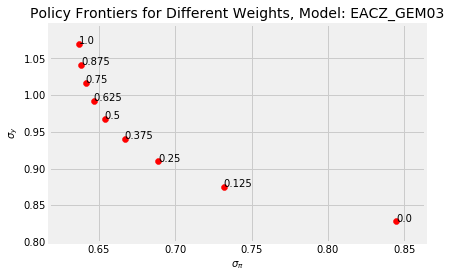

In [15]:
m44results = createFrontier(44)